In [1]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np

from fte.fitting.aipwe import get_aipwe_estimator

In [2]:
from fte.simulation.processes import simulate_gaussian_process

In [3]:
TIME_GRID = np.linspace(0, 2)

In [100]:
def propensity_score(x):
    return np.where(x < 1, 0.1, 0.9)

In [101]:
def _conditional_expectation(
    t: np.ndarray,
    d: np.ndarray,
    x: np.ndarray,
):
    if isinstance(t, np.ndarray) and isinstance(d, np.ndarray):
        t = t.reshape(1, -1)
        d = d.reshape(-1, 1)

    if isinstance(x, np.ndarray):
        x = x.reshape(-1, 1)

    return x * np.sin(d * t + (1 - d) * t**2)


conditional_expectation = partial(_conditional_expectation, t=TIME_GRID)

In [102]:
def average_treatment_effect(t):
    return _conditional_expectation(t=t, d=1, x=1) - _conditional_expectation(
        t=t,
        d=0,
        x=1,
    )

## Plotting

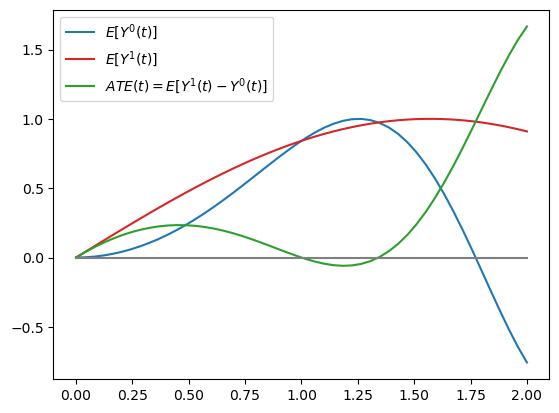

In [103]:
g0 = conditional_expectation(t=TIME_GRID, d=0, x=1)
g1 = conditional_expectation(t=TIME_GRID, d=1, x=1)

fig, ax = plt.subplots(1, 1)
ax.plot(TIME_GRID, g0, color="tab:blue")
ax.plot(TIME_GRID, g1, color="tab:red")
ax.plot(TIME_GRID, g1 - g0, color="tab:green")
ax.plot(TIME_GRID, np.zeros_like(TIME_GRID), color="tab:gray")
ax.legend(
    labels=["$E[Y^{0}(t)]$", "$E[Y^{1}(t)]$", "$ATE(t) = E[Y^{1}(t) - Y^{0}(t)]$"],
)

### Simulate

In [104]:
def simulate(n_samples: int, rng: np.random.Generator):
    x = rng.uniform(0.5, 1.5, size=n_samples)
    treatment_probability = propensity_score(x)
    d = rng.binomial(1, p=treatment_probability, size=n_samples)

    g = conditional_expectation(t=TIME_GRID, d=d, x=x)

    error = simulate_gaussian_process(
        n_periods=len(TIME_GRID),
        n_samples=n_samples,
        kernel="RBF",
        rng=rng,
        scale=0.02,
    )

    y = g + error.T
    return x, d.astype(bool), y

In [105]:
rng = np.random.default_rng(12345)

x, d, y = simulate(1_000, rng=rng)

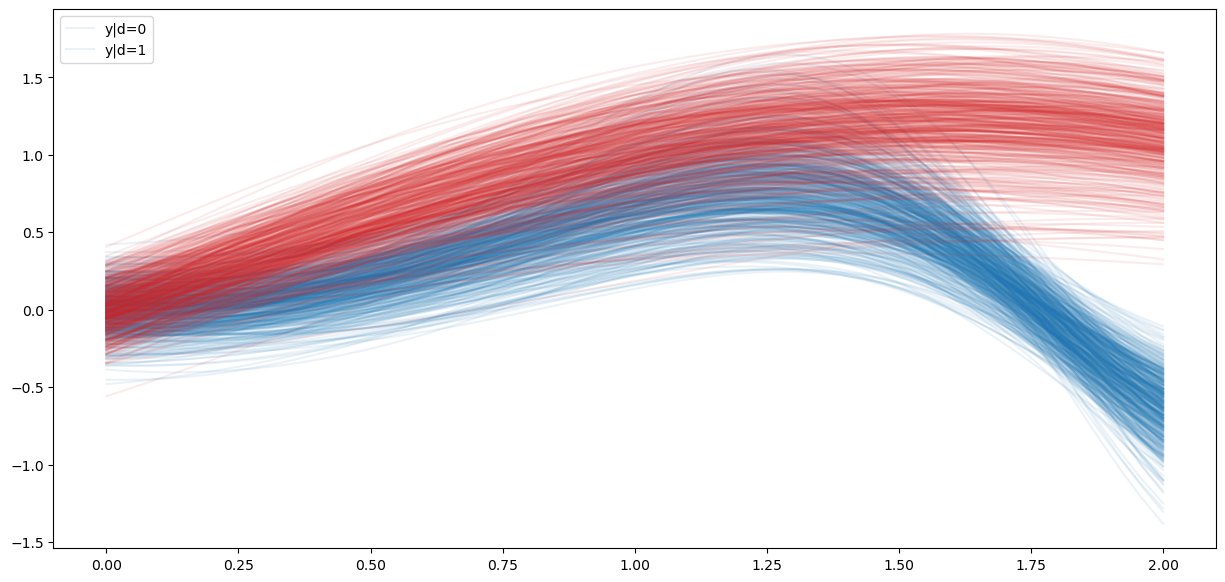

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

_ = ax.plot(TIME_GRID, y[~d].T, color="tab:blue", alpha=0.09)
_ = ax.plot(TIME_GRID, y[d].T, color="tab:red", alpha=0.09)
ax.legend(labels=["y|d=0", "y|d=1"])

### Estimation

In [107]:
def mean_difference(d, y):
    return y[d].mean(axis=0) - y[~d].mean(axis=0)

In [108]:
aipwe_estimator = get_aipwe_estimator(
    name="oracle",
    conditional_expectation=conditional_expectation,
    propensity_score=propensity_score,
)

In [109]:
res = {
    "ate": average_treatment_effect(TIME_GRID),
    "mean_difference": mean_difference(d=d, y=y),
    "aipwe": aipwe_estimator(x=x, y=y, d=d)["estimate"],
}

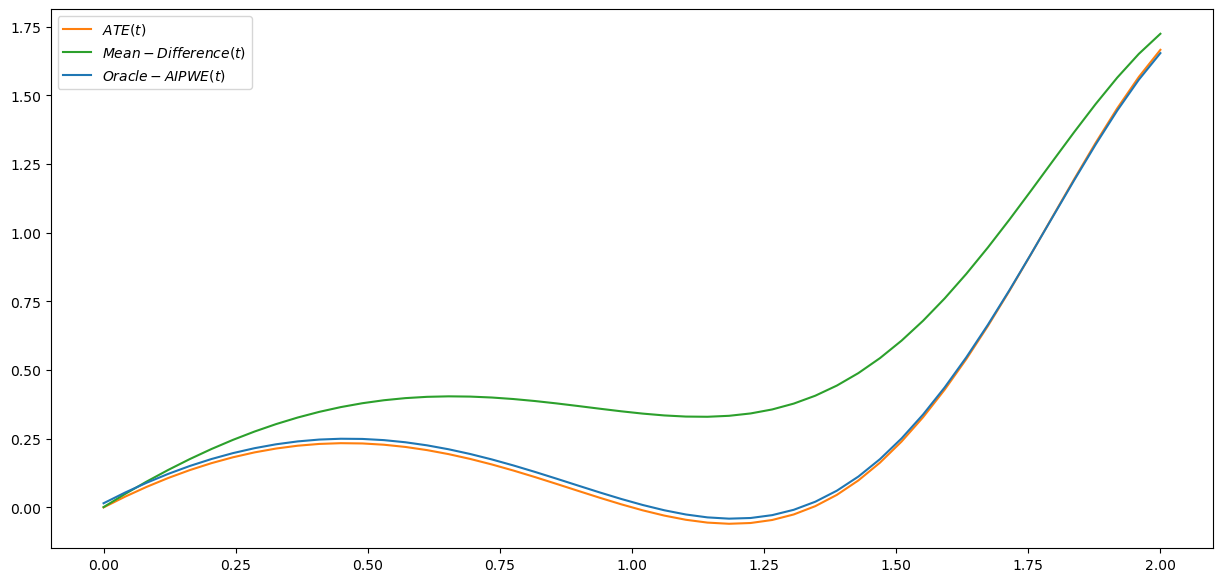

In [111]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

_ = ax.plot(TIME_GRID, res["ate"], color="tab:orange")
_ = ax.plot(TIME_GRID, res["mean_difference"], color="tab:green")
_ = ax.plot(TIME_GRID, res["aipwe"], color="tab:blue")
ax.legend(labels=["$ATE(t)$", "$Mean-Difference(t)$", "$Oracle-AIPWE(t)$"])